## Variables
We need to define some variables for CUDA kernel.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
np.random.seed(1234)
cuda.select_device(0)

global stream, dR, dP, dU, dI

K = 20

In [2]:
file = open("yelp_train.txt", 'r')
lines = file.readlines()
numberOfUsers = 0
numberOfItems = 0
userID = np.zeros((len(lines)), dtype=int)
itemID = np.zeros((len(lines)), dtype=int)
rating = np.zeros((len(lines)))
count = 0

print("Preparing data.........")
for line in lines:
    listOfLine = line.split("\n")[0].split(",")
    userID[count] = int(listOfLine[0])
    # print(userID[count])
    
    if userID[count] + 1 > numberOfUsers:
        numberOfUsers = userID[count] + 1
        
    itemID[count] = int(listOfLine[1])
    # print(itemID[count])
    if itemID[count] + 1 > numberOfItems:
        numberOfItems = itemID[count] + 1
    rating[count] = float(listOfLine[2])
    count = count + 1
print("Finish preparing data")

Preparing data.........
Finish preparing data


In [3]:
rating_matrix = np.zeros((numberOfUsers, numberOfItems))
for line in lines:
    listOfLine = line.split("\n")[0].split(",")
    uID = int(listOfLine[0])    
    iID = int(listOfLine[1])
    r = float(listOfLine[2])
    rating_matrix[uID, iID] = r
#     count = count + 1

print("Finish preparing data")

Finish preparing data


In [36]:
K = 4
numberOfUsers = 50
numberOfItems = 50
rating_matrix = np.random.rand(numberOfUsers, numberOfItems)

In [40]:
hR = rating_matrix
# user vector
hU = np.asarray(np.random.rand(numberOfUsers, K), dtype=np.float32)

# item vector
hI = np.asarray(np.random.rand(K, numberOfItems), dtype=np.float32)

# predicted ratings
hP = np.zeros(rating_matrix.shape)

# for calculate errors with CUDA kernel
hErr = np.zeros((numberOfUsers, numberOfItems), dtype=np.float32)
hUReg = np.zeros((numberOfUsers, K), dtype=np.float32)
hIReg = np.zeros((K, numberOfItems), dtype=np.float32)

# transfer the above variables to GPU
stream = cuda.stream()
with stream.auto_synchronize():
    dR = cuda.to_device(hR)
    dU = cuda.to_device(hU)
    dI = cuda.to_device(hI)
    dP = cuda.to_device(hP)
    dErr = cuda.to_device(hErr)
    dUReg = cuda.to_device(hUReg)
    dIReg = cuda.to_device(hIReg)
# auto_synchronize ensures that transfer processes finished

## Parameters

In [64]:
alpha = 0.05
beta = 0

`alpha` denotes learning rate. `beta` denotes the weight for regularization term.

In [42]:
blockdim = (32, 32)
griddim = (numberOfUsers//blockdim[0]+1, numberOfItems//blockdim[1]+1)

## CUDA kernels

In [43]:
# @cuda.jit('void(float32[:,:], float32[:,:], float32[:,:])')
@cuda.jit
def predict(U, I, P):
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y
    x = tx + bx * bw
    y = ty + by * bh
    
    if x < P.shape[0] and y < P.shape[1]:
        P[x, y] = 0
        for k in range(K):
            P[x, y] += U[x, k] * I[k, y]
            cuda.syncthreads()

In [44]:
# @cuda.jit('void(float32[:,:], float32[:,:], float32[:,:], float32[:,:], float32[:,:], float32[:,:], float32[:,:])')
@cuda.jit
def error(R, P, U, I, Err, UReg, IReg):
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    j = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    
    if i < Err.shape[0] and j < Err.shape[1]:
        Err[i, j] = 0
        if R[i, j] != 0:
            for k in range(K):
                UReg[i, k] = U[i, k] ** 2
                IReg[k, j] = I[k, j] ** 2
            Err[i, j] = (R[i, j] - P[i, j]) ** 2

# @cuda.jit('void(float32[:,:], float32[:,:], float32[:,:], float32[:,:])')
@cuda.jit
def factorize(R, P, U, I):
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    j = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
    
    if i < R.shape[0] and j < R.shape[1]:
    
        if R[i, j] != 0:
            for k in range(K):
    #             err_U = (R[i, j] - P[i, j]) * I[j, k]
                err_U = 0
                for c in range(R.shape[1]):
                    if R[i, c] != 0:
                        err_U += (R[i, c] - P[i, c]) * I[k, c]
                err_I = 0
                for c in range(R.shape[0]):
                    if R[c, j] != 0:
                        err_I += (R[c, j] - P[c, j]) * U[c, k]
    #             err_I = (R[i, j] - P[i, j]) * U[i, k]

                U[i, k] += alpha * 2 * (err_U - beta * U[i, k])
                I[k, j] += alpha * 2 * (err_I - beta * I[k, j])
        else:
            return


In [65]:
# test error func

In [78]:
np.multiply(hP - hR, hP - hR).sum()

1.9837668267123182e+56

In [76]:
error[griddim, blockdim](hR, hP, hU, hI, hErr, hUReg, hIReg)
stream.synchronize()

In [77]:
hErr

array([[             inf,              inf,              inf, ...,
                     inf,              inf,              inf],
       [             inf,              inf,              inf, ...,
                     inf,              inf,              inf],
       [             inf,              inf,              inf, ...,
                     inf,              inf,              inf],
       ..., 
       [             inf,              inf,              inf, ...,
          6.15480317e+37,   1.49759339e+38,   1.14645489e+38],
       [             inf,              inf,              inf, ...,
          4.17713969e+37,   1.01633532e+38,   7.78018122e+37],
       [             inf,              inf,              inf, ...,
          3.18117669e+38,              inf,              inf]], dtype=float32)

## Perform Matrix Factorization

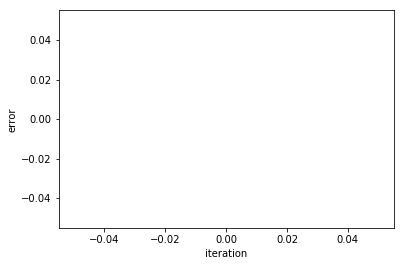

In [61]:
# def run_mf(iter=500):
errors = []
for i in range(1):
#     print(i)
    predict[griddim, blockdim, stream](dU, dI, dP)
    stream.synchronize()
#     cuda.syncthreads()

    factorize[griddim, blockdim, stream](dR, dP, dU, dI)
    stream.synchronize()
#     cuda.syncthreads()

    error[griddim, blockdim, stream](dR, dP, dU, dI, dErr, dUReg, dIReg)
    stream.synchronize()
#     cuda.syncthreads()

    Err = np.sum(dErr.copy_to_host())
    UReg = np.sum(dUReg.copy_to_host())
    IReg = np.sum(dIReg.copy_to_host())
    errors.append(Err + beta * (UReg + IReg))
    hP = dP.copy_to_host()
    hU = dU.copy_to_host()
    hI = dI.copy_to_host()
#     print(Err)
#     print(hU[0])
#     print(hI[0])
#     print(hP[0])

plt.plot(errors)
plt.xlabel('iteration')
plt.ylabel('error')
plt.show()

In [62]:
hU.sum()

nan

## Result

In [76]:
print('Observed rating matrix')
print(hR)
print('-' * 50)
print('Predicted rating matrix')
print(dU.copy_to_host().dot(dI.copy_to_host()))

Observed rating matrix
[[ 5.  3.  0.  1.]
 [ 4.  0.  0.  1.]
 [ 1.  1.  0.  5.]
 [ 1.  0.  0.  4.]
 [ 0.  1.  5.  4.]]
--------------------------------------------------
Predicted rating matrix
[[ 0.30877635  0.38768598  0.31201467 ...,  0.30620095  0.73620611
   0.40741983]
 [ 0.56883901  0.89716887  0.5537101  ...,  0.59741771  1.22188342
   0.42181376]
 [ 0.75221169  1.0600642   0.74676991 ...,  0.76699609  1.70855331
   0.7847659 ]
 ..., 
 [ 0.3073698   0.57529587  0.28875893 ...,  0.33929792  0.59375763
   0.06528515]
 [ 0.29941389  0.28931412  0.31254068 ...,  0.28114071  0.77750266
   0.55070311]
 [ 0.20411971  0.34387603  0.1961613  ...,  0.21837075  0.42234066
   0.1119393 ]]


You can see that elements that have 0 in observed matrix have been filled with predicted values and observed values have been approximated. The estimated user vector and item vector are:

In [19]:
print('User vector')
print(dU.copy_to_host())
print('-' * 50)
print('Item vector')
print(dI.copy_to_host())

User vector
[[ 0.36731917  2.32105517]
 [ 0.37745658  1.78174734]
 [ 2.06740808  0.31214419]
 [ 1.63157201  0.31391308]
 [ 1.68681598  1.06579304]]
--------------------------------------------------
Item vector
[[ 0.195508    0.15095763  1.93585849  2.40482998]
 [ 2.15898776  1.16406178  1.45912766  0.04531301]]


Each row in user vector describe each user's feature and each column in item vector describe each item's feature.

(c) 2014 Shunta Saito. All Rights Reserved.